# Create EOPatch and fill it with L2A and derived data

Now is time to create an `EOPatch` for each out of 293 tiles of the AOI. The `EOPatch` is created by filling it with Sentinel-2 data using Sentinel Hub services. We will add the following data to each `EOPatch`:
* L2A RGB (bands B04, B03, and B02) 
* Sen2Cor's scene classification map

Using the above information we can then also count how many times in a time series a pixel is valid or not from the Sen2Cor's scene classification map.

---

An `EOPatch` is created and manipulated using `EOTasks` chained in an `EOWorkflow`. In this example the final workflow is a sequence of the following tasks:
1. Create `EOPatch` by filling it with RGB L2A data
2. Add Sen2Cor's scene classification map
3. Validate pixels using Sen2Cor's scene classification map
4. Count number of valid observations per pixel using valid data mask
5. Export valid pixel count to tiff file
6. Save EOPatch to disk

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

from tqdm import tqdm_notebook as tqdm

In [3]:
from eolearn.core import EOTask, EOPatch, LinearWorkflow, Dependency, FeatureType, SaveToDisk, OverwritePermission
from eolearn.io import ExportToTiff
from eolearn.io import S2L2AWCSInput, AddSen2CorClassificationFeature
from eolearn.mask import AddValidDataMaskTask
from eolearn.features import SimpleFilterTask

In [4]:
from sentinelhub import BBoxSplitter, CRS, MimeType, BBox, CustomUrlParam

In [5]:
import logging
logging.getLogger("requests").setLevel(logging.WARNING)
logging.getLogger("urllib3").setLevel(logging.WARNING)

In [6]:
import pickle

In [7]:
from pathlib import Path

In [8]:
data = Path('./')

In [9]:
import os

In [10]:
if not os.path.exists(data/'data'/'valid_count'):
    os.makedirs(data/'data'/'valid_count')

### Get BBoxSplitter with tile definitions

In [11]:
with open(data/'tile-def'/'slovenia_buffered_bbox_32633_17x25_293.pickle','rb') as fp:
    bbox_splitter = pickle.load(fp)

In [12]:
len(bbox_splitter.bbox_list)

293

In [13]:
bbox_splitter.bbox_list[0]

BBox(((370230.5261411405, 5085303.344972428), (380225.31836121203, 5095400.767924464)), crs=EPSG:32633)

In [14]:
bbox_splitter.info_list[0]

{'parent_bbox': BBox(((370230.5261411405, 5024718.807260214), (620100.3316429297, 5196374.997444821)), crs=EPSG:32633),
 'index_x': 0,
 'index_y': 6}

# eo-learn Workflow to create patches

### Define what makes a pixel valid

#### Sen2Cor's definition of valid pixel

Valid pixel is if:
   * `IS_DATA == True` (`IS_DATA` is returned by Sentinel Hub and indicates which pixels are valid. For example if BBOX is at orbit border than part of the image -- outside the orbit -- will be invalid (empty).)
   * Sen2Cor's scene classification values are none of the following:
       * 0 (NO DATA)
       * 1 (Saturated or defective pixel)
       * 3 (Cloud shadows)
       * 8 (Cloud medium probability)
       * 9 (Cloud high probability)
       * 10 (Thin cirrus)

In [15]:
class Sen2CorValidData:
    """
    Combine Sen2Cor's classification map with `IS_DATA` to define a `VALID_DATA_S2C` mask
    
    The Sen2Cor's classification map is asumed to be found in eopatch.mask['SCL']
    """
    def __call__(self, eopatch):
        sen2cor_valid = np.zeros_like(eopatch.mask['SCL'], dtype=np.bool)
        
        valid_classes = [2, 4, 5, 6, 7, 11]
        for valid in valid_classes:
            sen2cor_valid = np.logical_or(sen2cor_valid, (eopatch.mask['SCL']==valid).astype(np.bool))
        
        return np.logical_and(eopatch.mask['IS_DATA'].astype(np.bool), sen2cor_valid)

### Define custom tasks

In [16]:
class CountValid(EOTask):   
    """
    The task counts number of valid observations in time-series and stores the results in the timeless mask.
    """
    def __init__(self, count_what, feature_name):
        self.what = count_what
        self.name = feature_name
        
    def execute(self, eopatch):
        eopatch.add_feature(FeatureType.MASK_TIMELESS, self.name, np.count_nonzero(eopatch.mask[self.what],axis=0))
        
        return eopatch

In [17]:
def valid_fraction(arr):
    """
    Calculates fraction of non-zero pixels.
    """
    return np.count_nonzero(arr)/np.size(arr)

In [18]:
class AddValidDataFraction(EOTask):
    """
    Tasks determines the fraction of non-zero pixels in user specified MASK and adds it to EOPatch's scalar feature.
    """
    def __init__(self, scalar_name, mask_name):
        self.scalar_name = scalar_name
        self.mask_name = mask_name
        
    def execute(self, eopatch):
        vld = eopatch.get_feature(FeatureType.MASK, self.mask_name)
        frac = np.apply_along_axis(valid_fraction, 1, np.reshape(vld, (vld.shape[0], -1)))
        
        eopatch.add_feature(FeatureType.SCALAR, self.scalar_name, frac[:,np.newaxis])
        return eopatch

In [19]:
class ValidDataFractionPredicate:
    """
    Predicate that defines if a frame from EOPatch's time-series is valid or not. Frame is valid, if the 
    valid data fraction is above the specified threshold.
    """
    def __init__(self, threshold):
        self.threshold = threshold
        
    def __call__(self, array):
        coverage = array[...,0]
        return coverage > self.threshold

## Initialise tasks

In [20]:
INSTANCE_ID = None

In [21]:
# 1. Create `EOPatch` by filling it with RGB L2A data
# Add TRUE COLOR from L2A
# The `TRUE-COLOR-S2-L2A` needs to be defined in your configurator
input_task = S2L2AWCSInput('TRUE-COLOR-S2-L2A', resx='10m', resy='10m', maxcc=0.8, instance_id=INSTANCE_ID)

# 2. Add Sen2Cor's scene classification map
add_SCL = AddSen2CorClassificationFeature(sen2cor_classification='SCL',layer='TRUE-COLOR-S2-L2A',image_format=MimeType.TIFF_d32f)
add_CLD = AddSen2CorClassificationFeature(sen2cor_classification='CLD',layer='TRUE-COLOR-S2-L2A',image_format=MimeType.TIFF_d32f)

# 3. Validate pixels using Sen2Cor's scene classification map
add_s2c_valmask = AddValidDataMaskTask(Sen2CorValidData(), 'VALID_DATA_S2C')

# 4. Count number of valid observations per pixel using valid data mask
count_val_s2c = CountValid('VALID_DATA_S2C', 'VALID_COUNT_S2C')

# 5. Calculate fraction of valid pixels
add_coverage = AddValidDataFraction('VALID_FRAC', 'VALID_DATA_S2C')

# 6. Remove frames with fraction of valid pixels below 60%
remove_cloudy_scenes = SimpleFilterTask((FeatureType.SCALAR, 'VALID_FRAC'),ValidDataFractionPredicate(0.6))

# 7. Export valid pixel count to georeferenced tiff file
export_val_s2c = ExportToTiff((FeatureType.MASK_TIMELESS, 'VALID_COUNT_S2C'))

# 8. Save EOPatch to disk
save = SaveToDisk(str(data/'data'/'eopatch'), overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

## Define workflow

In this example the workflow is linear

In [22]:
workflow = LinearWorkflow(input_task, 
                          add_SCL, add_CLD, 
                          add_s2c_valmask, count_val_s2c, 
                          add_coverage, remove_cloudy_scenes,
                          export_val_s2c, save)

In [23]:
info = bbox_splitter.info_list[0]

In [24]:
info

{'parent_bbox': BBox(((370230.5261411405, 5024718.807260214), (620100.3316429297, 5196374.997444821)), crs=EPSG:32633),
 'index_x': 0,
 'index_y': 6}

Execute the workflow on the first tile

In [25]:
time_interval = ['2017-01-01','2017-12-31']

idx = 118
bbox = bbox_splitter.bbox_list[idx]
info = bbox_splitter.info_list[idx]
tiff_name = f'val_count_s2c_eopatch_{idx}_row-{info["index_x"]}_col-{info["index_y"]}.tiff'
patch_name = f'eopatch_{idx}_row-{info["index_x"]}_col-{info["index_y"]}'
results = workflow.execute({input_task:{'bbox':bbox, 'time_interval':time_interval},
                            export_val_s2c:{'filename':str(data/'data'/'valid_count'/tiff_name)},
                            save:{'eopatch_folder':patch_name}
                           })

In [26]:
patch = list(results.values())[-1]

#### Check the content of the EOPatch

In [27]:
patch.get_features()

{<FeatureType.DATA: 'data'>: {'CLD', 'TRUE-COLOR-S2-L2A'},
 <FeatureType.MASK: 'mask'>: {'IS_DATA', 'SCL', 'VALID_DATA_S2C'},
 <FeatureType.SCALAR: 'scalar'>: {'VALID_FRAC'},
 <FeatureType.MASK_TIMELESS: 'mask_timeless'>: {'VALID_COUNT_S2C'},
 <FeatureType.META_INFO: 'meta_info'>: {'maxcc',
  'service_type',
  'size_x',
  'size_y',
  'time_difference',
  'time_interval'},
 <FeatureType.BBOX: 'bbox'>: True,
 <FeatureType.TIMESTAMP: 'timestamp'>: True}

In [28]:
patch.timestamp

[datetime.datetime(2017, 1, 1, 10, 4, 7),
 datetime.datetime(2017, 1, 11, 10, 3, 51),
 datetime.datetime(2017, 2, 20, 10, 6, 35),
 datetime.datetime(2017, 3, 12, 10, 7, 6),
 datetime.datetime(2017, 4, 1, 10, 0, 22),
 datetime.datetime(2017, 4, 21, 10, 5, 41),
 datetime.datetime(2017, 5, 21, 10, 0, 29),
 datetime.datetime(2017, 5, 31, 10, 5, 36),
 datetime.datetime(2017, 6, 20, 10, 4, 53),
 datetime.datetime(2017, 7, 5, 10, 0, 26),
 datetime.datetime(2017, 7, 10, 10, 5, 40),
 datetime.datetime(2017, 7, 20, 10, 0, 27),
 datetime.datetime(2017, 7, 25, 10, 5, 36),
 datetime.datetime(2017, 7, 30, 10, 5, 35),
 datetime.datetime(2017, 8, 24, 10, 0, 22),
 datetime.datetime(2017, 8, 29, 10, 0, 26),
 datetime.datetime(2017, 9, 28, 10, 6, 17),
 datetime.datetime(2017, 10, 8, 10, 3, 22),
 datetime.datetime(2017, 10, 13, 10, 0, 12),
 datetime.datetime(2017, 10, 18, 10, 2),
 datetime.datetime(2017, 11, 27, 10, 3, 39)]

#### Plot RGB, SCL, and Cloud probability, and number of valid observations

In [29]:
def plot_frame(patch, idx):
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20,20)) 

    axs[0,0].imshow(patch.data['TRUE-COLOR-S2-L2A'][idx])
    axs[0,0].set_title(f'RGB {patch.timestamp[idx]}') 
    axs[0,1].imshow(patch.mask['VALID_DATA_S2C'][idx, ..., 0])
    axs[0,1].set_title(f'Valid data {patch.timestamp[idx]}') 
    axs[1,0].imshow(patch.mask['SCL'][idx,...,0])
    axs[1,0].set_title(f'Sen2Cor Scene Classification {patch.timestamp[idx]}') 
    axs[1,1].imshow(patch.data['CLD'][idx,...,0],cmap=plt.cm.inferno)
    axs[1,1].set_title(f'Sen2Cor Cloud Probability {patch.timestamp[idx]}') 

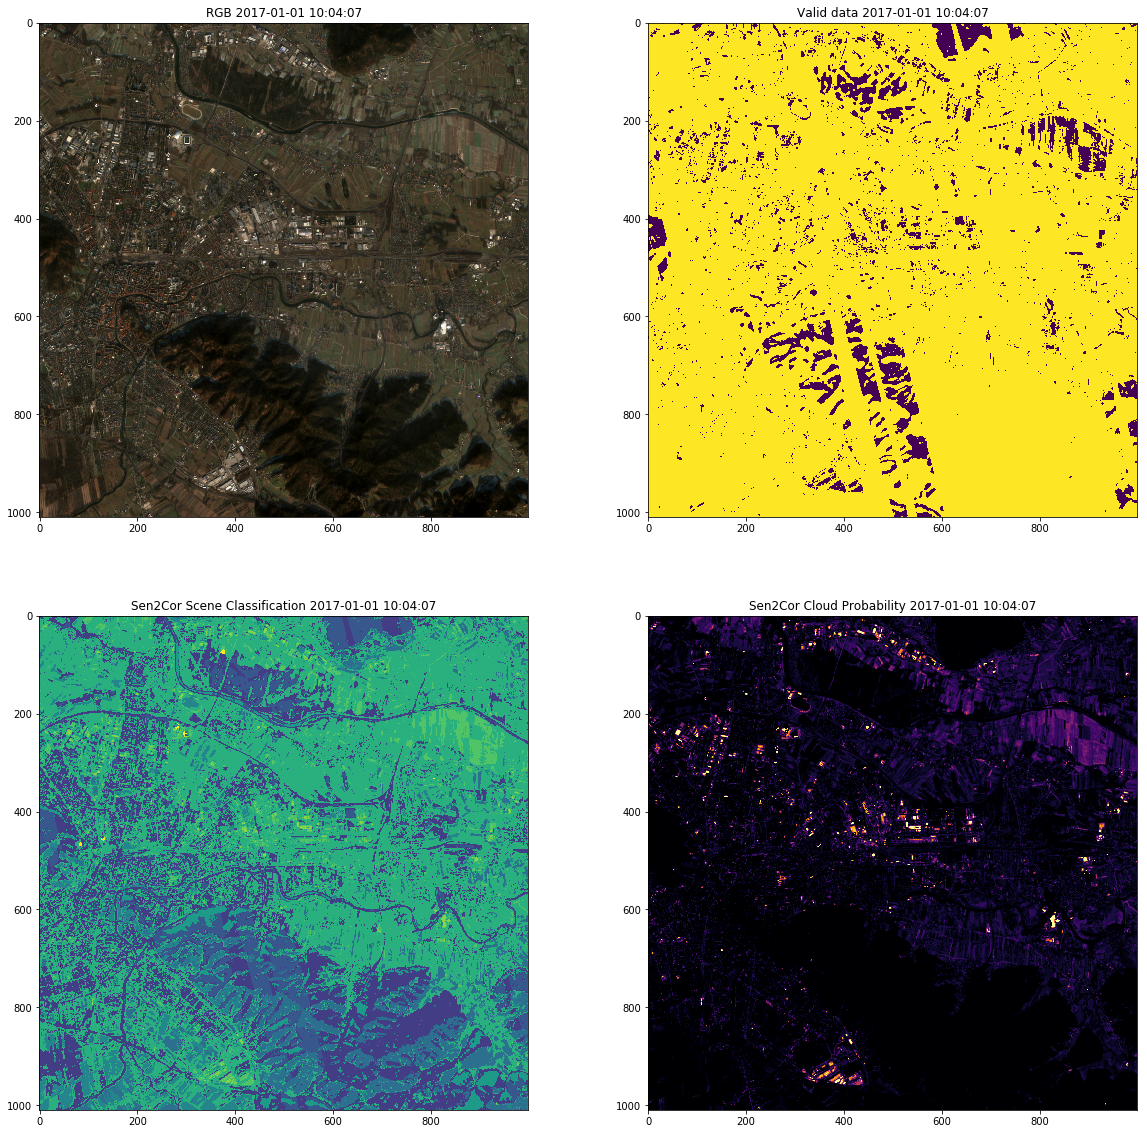

In [30]:
plot_frame(patch, 0)

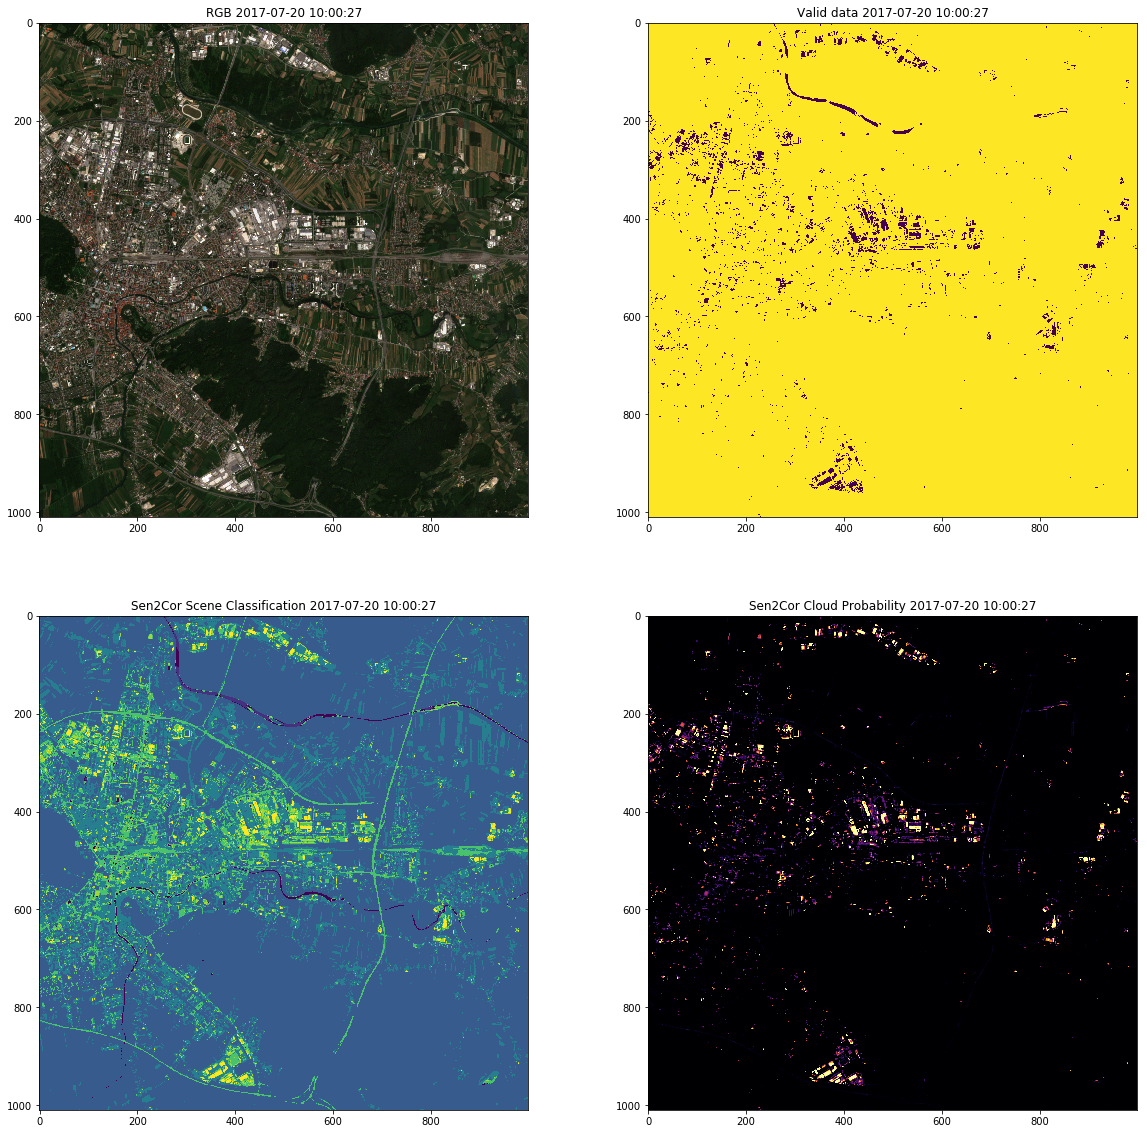

In [31]:
plot_frame(patch, -10)

#### Plot number of valid observations

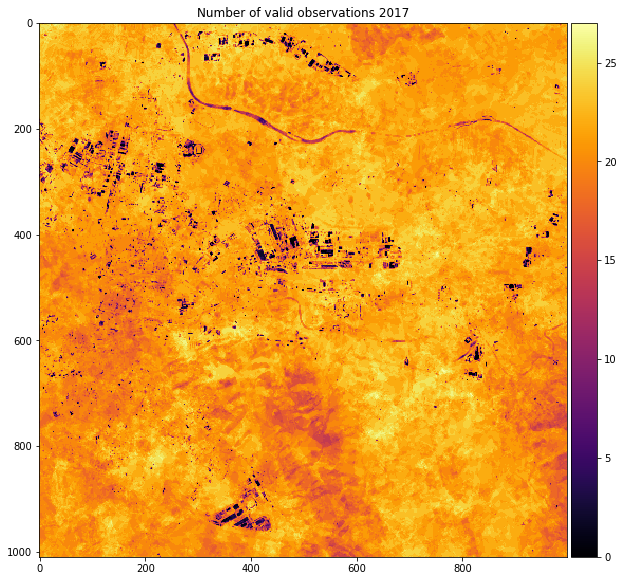

In [32]:
fig, ax = plt.subplots(figsize=(10,10)) 
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
im = ax.imshow(patch.mask_timeless['VALID_COUNT_S2C'][...,0], cmap=plt.cm.inferno, vmin=0, vmax=np.max(patch.mask_timeless['VALID_COUNT_S2C']))
ax.set_title('Number of valid observations 2017');
fig.colorbar(im, cax=cax, orientation='vertical')

#### Plot average cloud probability

In [33]:
avecld = np.sum(patch.data['CLD'][...,0],axis=(0))/patch.data['CLD'].shape[0]

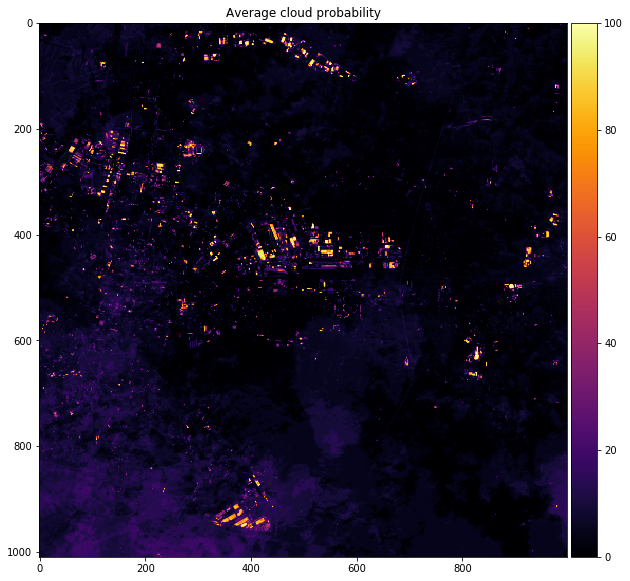

In [34]:
fig, ax = plt.subplots(figsize=(10,10)) 
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
im = ax.imshow(avecld, cmap=plt.cm.inferno, vmin=0, vmax=100.0)
ax.set_title('Average cloud probability');
fig.colorbar(im, cax=cax, orientation='vertical')

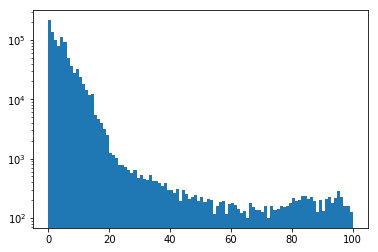

In [35]:
plt.hist((avecld).flatten(),range=(0,100), bins=100, log=True);

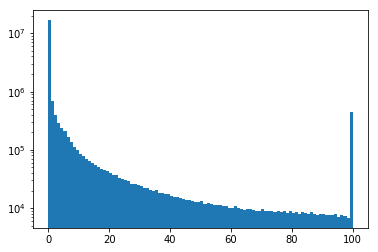

In [36]:
plt.hist((patch.data['CLD']).flatten(),range=(0,100), bins=100, log=True);

#### Plot fraction of valid pixels per frame

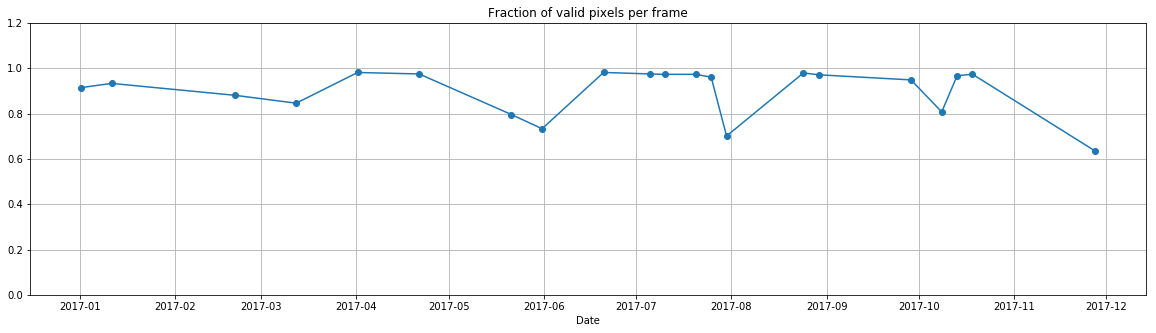

In [37]:
fig, ax = plt.subplots(figsize=(20,5)) 
ax.plot(patch.timestamp, patch.scalar['VALID_FRAC'],'o-')
ax.set_title('Fraction of valid pixels per frame');
ax.set_xlabel('Date');
ax.set_ylim(0.0,1.2)
ax.grid()
fig.savefig('figs/s2c_fraction_valid_pixels_per_frame_eopatch-0.png', bbox_inches='tight')

## Run workflow on all tiles

Note that this can take time. For this purpose we'll simplify the workflow, download minimal ammount of data and store only number of valid observations to disk. 

In [38]:
# 1. Create `EOPatch` by filling it with RGB L2A data
# Add B02 from L2A
input_task = S2L2AWCSInput('TRUE-COLOR-S2-L2A', feature='B02', resx='10m', resy='10m', maxcc=0.8, instance_id=INSTANCE_ID, 
                           custom_url_params={CustomUrlParam.EVALSCRIPT:'return [B02]'})

In [39]:
workflow = LinearWorkflow(input_task, 
                          add_SCL, add_CLD, 
                          add_s2c_valmask, count_val_s2c, 
                          add_coverage, remove_cloudy_scenes,
                          export_val_s2c)

In [40]:
def execute_workflow(tile_idx):
    bbox = bbox_splitter.bbox_list[tile_idx]
    info = bbox_splitter.info_list[tile_idx]
    tiff_name = f'val_count_s2c_eopatch_{tile_idx}_row-{info["index_x"]}_col-{info["index_y"]}.tiff'
    patch_name = f'eopatch_{tile_idx}_row-{info["index_x"]}_col-{info["index_y"]}'
    results = workflow.execute({input_task:{'bbox':bbox, 'time_interval':time_interval},
                                export_val_s2c:{'filename':str(data/'data'/'valid_count'/tiff_name)},
                               })
    del results

#### Run over all patches

In [ ]:
pbar = tqdm(total=len(bbox_splitter.bbox_list))

for idx in range(0, len(bbox_splitter.bbox_list)):
    execute_workflow(idx)
    pbar.update(1)